# Preliminary Analysis of Statement Sentiment by Lexicon
Analyse statement by Loughran and McDonald word list to see if the relationship between economy and net sentiment 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akalodzitsa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
plt.style.use('seaborn-whitegrid')

### Reading the data in (FOMC Statements)

In [29]:
file = open("../data/FOMC/statement.pickle", "rb")
Data = pd.read_pickle(file)

In [30]:
Data.tail(2)

,date,contents,speaker,title
192,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement
193,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement


In [31]:
Data['text'] = Data['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
Data.drop(columns=['title'], axis=1, inplace=True)

In [32]:
print('Date: ', Data.iloc[-1]['date'].strftime('%Y-%m-%d'))
print('Speaker: ', Data.iloc[-1]['speaker'])
print('Text: \n\n', Data.iloc[-1]['contents'].replace('\n[SECTION]\n', '')[1192:])

Date:  2021-12-15
Speaker:  Jerome Powell
Text: 

 The Federal Reserve is committed to using its full range of tools to support the U.S. economy in this challenging time, thereby promoting its maximum employment and price stability goals.

With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have improved in recent months but continue to be affected by COVID-19. Job gains have been solid in recent months, and the unemployment rate has declined substantially. Supply and demand imbalances related to the pandemic and the reopening of the economy have continued to contribute to elevated levels of inflation. Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to U.S. households and businesses.

The path of the economy continues to depend on the course of the virus. Progress on vacc

### Creating a Financial Dictionary based on Loughran and McDonald

In [33]:
#Dictionary tone assessment will compare them by Index (need the numbers back) 
Data['Index'] = range(0, len(Data))

# Make 'date' column as the index of Data
Data.set_index(['date'], inplace=True)
Data.head()

,contents,speaker,text,Index
date,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,0
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,1
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,2
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...,3
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...,4


In [34]:
import re

# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [35]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [36]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3: # if one of the last three words is a negation word, the word will be assigned as negative 
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [37]:
print(len(Data))
temp = [tone_count_with_negation_check(lmdict,x) for x in Data.text]
temp = pd.DataFrame(temp)

Data['wordcount'] = temp.iloc[:,0].values
Data['NPositiveWords'] = temp.iloc[:,1].values
Data['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
Data['sentiment'] = (Data['NPositiveWords'] - Data['NNegativeWords']) / Data['wordcount'] * 100

Data['Poswords'] = temp.iloc[:,3].values
Data['Negwords'] = temp.iloc[:,4].values


194


In [38]:
temp.head()

,0,1,2,3,4
0,99,4,2,"[increase, increase, enhance, expansion]","[less, misunderstanding]"
1,40,2,0,"[increase, increase]",[]
2,37,2,0,"[increase, increase]",[]
3,160,5,0,"[favorable, expansion, increase, effective, in...",[]
4,137,6,2,"[strength, expansion, high, sustainable, growt...","[against, least]"


In [39]:
Data.head()

,contents,speaker,text,Index,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
date,,,,,,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,0,99,4,2,2.020202,"[increase, increase, enhance, expansion]","[less, misunderstanding]"
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,1,40,2,0,5.000000,"[increase, increase]",[]
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,2,37,2,0,5.405405,"[increase, increase]",[]
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...,3,160,5,0,3.125000,"[favorable, expansion, increase, effective, in...",[]
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...,4,137,6,2,2.919708,"[strength, expansion, high, sustainable, growt...","[against, least]"


### Plots of the sentiment analysis

Plot positive and negative word counts

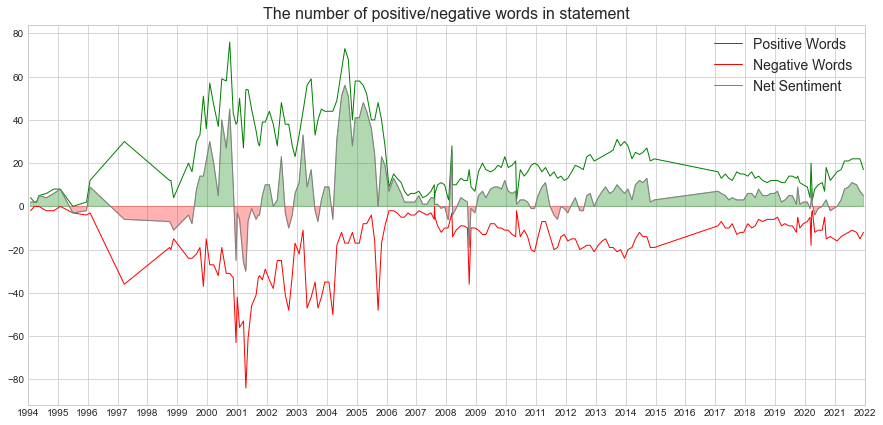

In [40]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(Data.index, Data['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(Data.index, Data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(Data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(Data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(Data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.grid(True)

plt.show()

Positive and negative word counts highly correlate... probably because of the total number of words varies. Take the positive - negative as Net Sentiment.

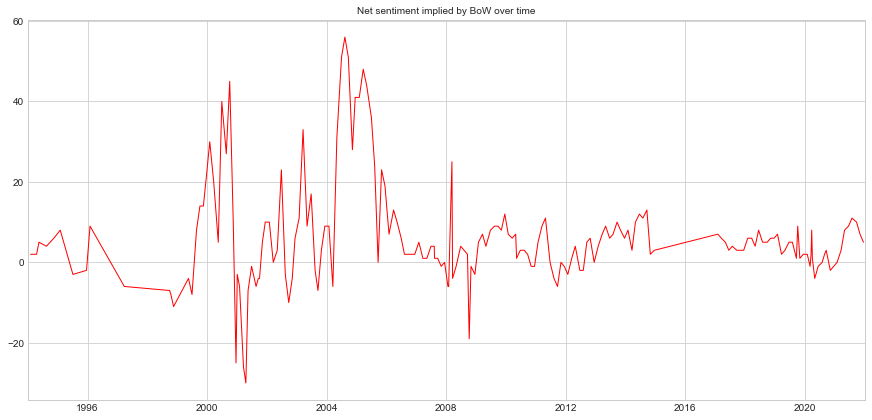

In [41]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

Plot derivative to see the changes in net sentiment

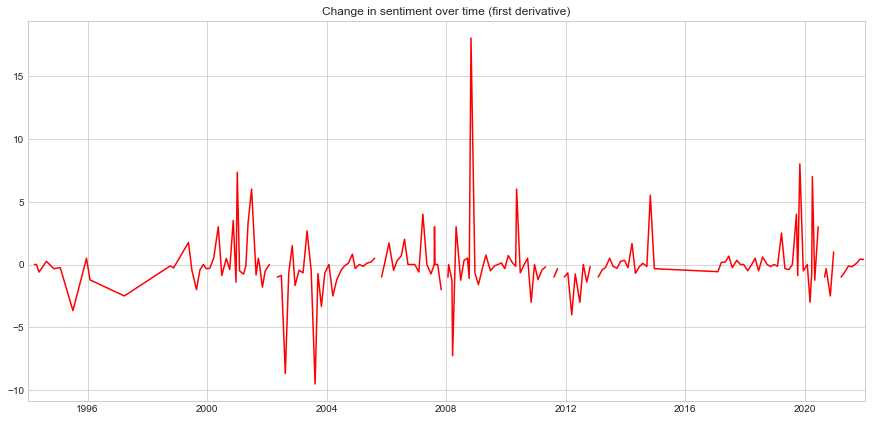

In [42]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

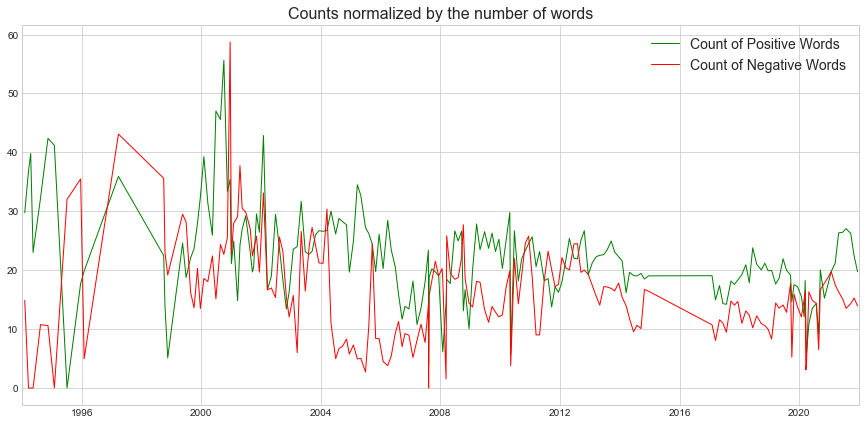

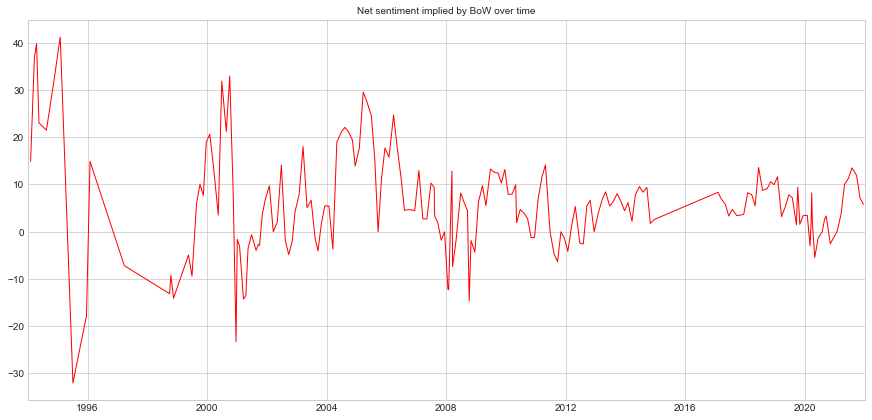

In [43]:
# Normalize data
NPositiveWordsNorm = Data['NPositiveWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NNegativeWordsNorm = Data['NNegativeWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(Data.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

### Function for extracting the direction of the rate change (hike, keep, lower)

Gets Basis Points Move and End Rate Value for Fed Rate and Discount Rate as well as Preferred Fed Rate Move from Statement Text

$\color{red}{Note:}$ The below functions could not be used in the analysis.  

In [44]:
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def ExtractKeyValues(text):
    
    '''
    First, the text is tokenized in to sentences and the fed funds target rate sentence is extracted 
    Secondly, the decision whether the fed target rate was hiked, kept or lowered is retreived to RateHike variable
    Third, the target rate range is extracted and saved in TargetRange (The max is extracted as it conveys most info)
    '''
    
    Potentials = [] #For storing the potential decision sentences
        
    #Remove the \n and replace them with dots 
    text = text.replace('\\n','. ')
       
    #Split the text in to a list of sentences
    #Note: a sentence can have several sentences 
    paragraph_sentence_list = tokenizer.tokenize(text)
    #print('paragraph_sentence_list: ', paragraph_sentence_list)
        
    #Finds the sentences with the decisions 
    for Sentence in paragraph_sentence_list:
        
        #print('Sentence: ', Sentence)
        #Make the text lower case
        Sentence = Sentence.lower()

        if 'federal funds ' in Sentence and  'target'  in Sentence:
            
            #Check if it contains a number
            if bool(re.search(r'\d', Sentence)):
                
                Potentials.append(Sentence)
        
    Potentials = ''.join(Potentials)  # join potencial sentences with fed funds target rate 
    #print('Potentials: ', Potentials)

    
    #Look for decision words related to raising rates
    r = Potentials.find('rais')
    i = Potentials.find('increas')
    upscore = max([r,i])
    
    #Look for decision words related to keeping rates
    k = Potentials.find('keep')
    m = Potentials.find('maintain')
    r = Potentials.find('remain')
    c = Potentials.find('current')
    keepscore = max([r,k,m,c])
    
    #Look for decision words related to decreasing rates
    l = Potentials.find('lower')
    d = Potentials.find('decreas')
    lowerscore = max([l,d])
    
    Summary = {1:upscore,
              0: keepscore,
              -1:lowerscore
              }
        
    #take the key that was mentioned first in the text
    RateHike = max(Summary.keys(), key=(lambda x: Summary[x]))

    #For extracting the target range 
    def RangeReader(Nums):
        
        def FractionReader(Fraction):
            
            '''
            Converts the fraction to a float
            ''' 
            i = 0
            if '/' in Fraction:
                if ' ' in Fraction:
                    i, Fraction = Fraction.split(' ')
                if '-' in Fraction:
                    i, Fraction = Fraction.split('-')
                if '‑' in Fraction:
                    i, Fraction = Fraction.split('‑')
                N, D = Fraction.split('/')
                return float(i) + float(N) / float(D)
            
            else:
                return float(i)+float(Fraction)
        
        #Splits the range based on to or -
        Splitters = [' to ','-']
        
        for Splitter in Splitters:
            if Splitter in Nums:
                TargetRange = Nums.split(Splitter)
                return FractionReader(TargetRange[0]), FractionReader(TargetRange[1])
        
        #If there was no splitter in the range (no range)
        return FractionReader(Nums)
        
        
    #Find the percentage change and take the closest digits
    Rate = Potentials[ : Potentials.find('percent') -1 ]
    Rate = Rate[-16:]
    # print(Rate)
    if re.search("\d", Rate):
        Rate = Rate[ re.search("\d", Rate).start() : ]
        TargetRange = np.max(RangeReader(Rate))
    else:
        Rate = None
        TargetRange = None
      
    return RateHike, TargetRange

Appends decision, dummy and Moves and End Rate Values for Fed and Disc Rate also appends preferred fed rate Move while measuring the speed of the extraction

In [45]:
Data.tail()
#Data.drop(index=[pd.to_datetime("2020-03-03")], inplace=True)

,contents,speaker,text,Index,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
date,,,,,,,,,,
2021-06-16,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",189,585,21,12,1.538462,"[stable, stability, progress, progress, strong...","[challenging, strong, adversely, weak, crisis,..."
2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",190,599,22,11,1.836394,"[stable, stability, progress, strong, strength...","[challenging, strong, adversely, crisis, risks..."
2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",191,617,22,12,1.620746,"[stable, stability, progress, strong, strength...","[challenging, strong, adversely, slowed, crisi..."
2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",192,723,22,15,0.968188,"[stable, stability, progress, strong, strength...","[challenging, strong, adversely, slowed, imbal..."
2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",193,634,17,12,0.788644,"[stable, stability, progress, strong, strength...","[challenging, strong, adversely, unemployment,..."


Tried to take rate and decision from the statement text but it sometimes fails. Debugging takes time, so switch to use data instead of reading from text.

In [46]:
# import timeit

# start = timeit.timeit()

# #Append fed funds rates and decisions to dataframe
# Hikes = []
# TargetRate = []

# for i in range(len(Data)):
#     if Data.iloc[i,1] == True:
#         Hikes.append(np.nan)
#         TargetRate.append(np.nan)
#     else:
#         Hikes.append( ExtractKeyValues( Data.iloc[i,0] )[0] )
#         TargetRate.append( ExtractKeyValues( Data.iloc[i,0] )[1] )        
        
# Data['RateDecision'] = Hikes
# Data['FedFundRateEndValue'] = TargetRate

# end = timeit.timeit()

# print (str ( end - start ) + ' seconds elapsed for ' + str(i) + ' statements')

# Data.tail()

$\color{red}{Note: }$ After 2008, upper bound of fed rate range is used.  

In [47]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/Quandl/FRED_DFEDTAR.csv'
filename_from08u = '../data/MarketData/Quandl/FRED_DFEDTARU.csv'
filename_from08l = '../data/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0) # not used 
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df


/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_5541/2920212368.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))


,Rate
Date,
1982-09-27,10.25
1982-09-28,10.25
1982-09-29,10.25
1982-09-30,10.25
1982-10-01,10.00
...,...
2022-01-15,0.25
2022-01-16,0.25
2022-01-17,0.25


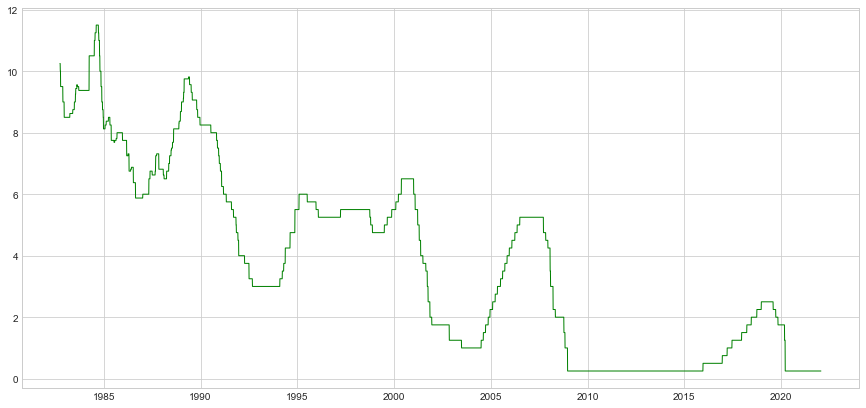

In [48]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, c = 'green', linewidth= 1.0)
ax.grid(True)
plt.show()

In [49]:
Data.shape

(194, 10)

In [50]:
Data.head()

,contents,speaker,text,Index,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
date,,,,,,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,0,99,4,2,2.020202,"[increase, increase, enhance, expansion]","[less, misunderstanding]"
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,1,40,2,0,5.000000,"[increase, increase]",[]
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,2,37,2,0,5.405405,"[increase, increase]",[]
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...,3,160,5,0,3.125000,"[favorable, expansion, increase, effective, in...",[]
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...,4,137,6,2,2.919708,"[strength, expansion, high, sustainable, growt...","[against, least]"


$\color {red}{Questions:}$ See comments below:

In [51]:
Data['RateDecision'] = None
Data['Rate'] = None

for i in range(len(Data)):
    for j in range(len(fedrate_df)):
        if Data.index[i] == fedrate_df.index[j]:
            Data['Rate'][i] = float(fedrate_df['Rate'][j+1])  #AK not sure why its; done this way -- j+1 is taken instead of j 
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = -1  # AK Is my interpretation correct?  0 --> keep rate , 1 --> increase rate,and -1 --> decrease rate 

Data.head(10)

/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_5541/2703188405.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Rate'][i] = float(fedrate_df['Rate'][j+1])  #AK not sure why its; done this way -- j+1 is taken instead of j
/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_5541/2703188405.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['RateDecision'][i] = 1
/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_5541/2703188405.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

,contents,speaker,text,Index,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords,RateDecision,Rate
date,,,,,,,,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,0,99,4,2,2.020202,"[increase, increase, enhance, expansion]","[less, misunderstanding]",1,3.25
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,1,40,2,0,5.000000,"[increase, increase]",[],1,3.5
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,2,37,2,0,5.405405,"[increase, increase]",[],1,3.75
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...,3,160,5,0,3.125000,"[favorable, expansion, increase, effective, in...",[],1,4.25
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...,4,137,6,2,2.919708,"[strength, expansion, high, sustainable, growt...","[against, least]",1,4.75
1994-11-15,\n\n[SECTION]\n\nThe Federal Reserve Board tod...,Alan Greenspan,The Federal Reserve Board today approved an in...,5,139,8,2,4.316547,"[increase, effective, increase, strength, high...","[against, persistent]",1,5.5
1995-02-01,\n\n[SECTION]\n\nFor immediate release\n\n[SEC...,Alan Greenspan,For immediate releaseThe Federal Reserve Board...,6,143,8,0,5.594406,"[increase, effective, increase, despite, growt...",[],1,6.0
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SEC...,Alan Greenspan,For immediate releaseChairman Alan Greenspan a...,7,69,0,3,-4.347826,[],"[decrease, tightening, decline]",-1,5.75
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SEC...,Alan Greenspan,For immediate releaseChairman Alan Greenspan a...,8,83,2,4,-2.409639,"[more, favorable]","[decrease, easing, easing, decline]",-1,5.5


In [52]:
def pickle_dump(df, filename='no-filename.pickle'):
    if filename:
        with open(filename, "wb") as output_file:
            pickle.dump(df, output_file)

### Plot the results and compare to the economical uncertainty / systemic risk periods

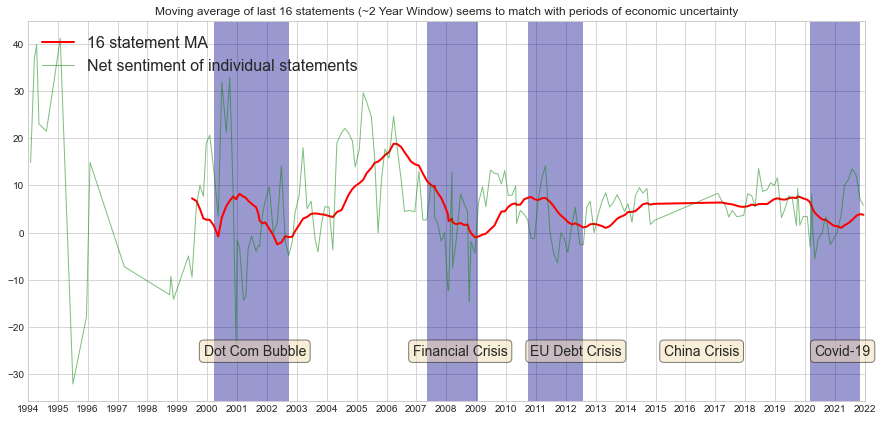

In [53]:
#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(Data.index > '2000-03', Data.index < '2002-10')

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
FinCrisis = np.logical_and(Data.index > '2007-04', Data.index < '2009-03')

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(Data.index > '2010-09', Data.index < '2012-09')

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(Data.index > '2015-01', Data.index < '2016-06')

#2020- Covid-19 Pandemic
#https://en.wikipedia.org/wiki/COVID-19_pandemic
Covid = np.logical_and(Data.index > '2020-02', Data.index < '2021-12')

Recessions = np.logical_or.reduce((DotCom, FinCrisis, EuroDebt, Asian, Covid))

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, CompToMA, c = 'r', linewidth= 2)
ax.plot(Data.index, NetSentimentNorm, c = 'green', linewidth= 1, alpha = 0.5)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty'))

ax.legend([str(str(Window) + ' statement MA'), 'Net sentiment of individual statements'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Recessions,
                facecolor='darkblue', alpha=0.4, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.21, 0.15, "Dot Com Bubble", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.46, 0.15, "Financial Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.60, 0.15, "EU Debt Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.76, 0.15, "China Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.94, 0.15, "Covid-19", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

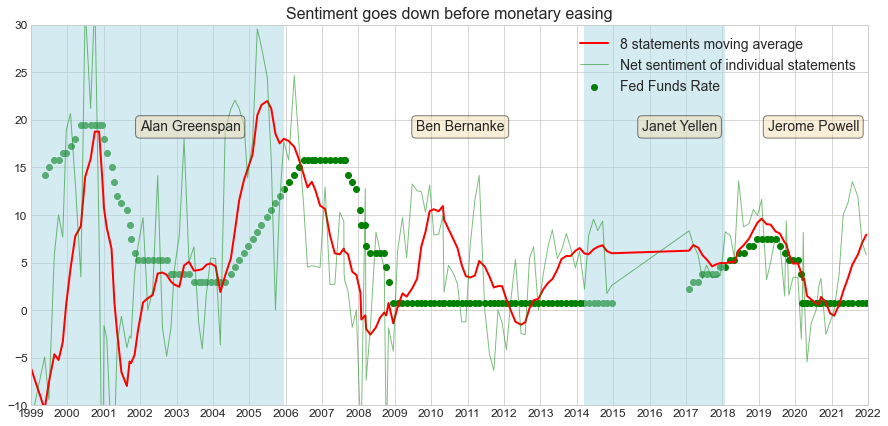

In [54]:
# Speaker window
Greenspan = np.logical_and(Data.index > '1987-08-11', Data.index < '2006-01-31')
Bernanke = np.logical_and(Data.index > '2006-02-01', Data.index < '2014-01-31')
Yellen = np.logical_and(Data.index > '2014-02-03', Data.index < '2018-02-03')
Powell = np.logical_and(Data.index > '2018-02-05', Data.index < '2022-02-05')
Speaker = np.logical_or.reduce((Greenspan, Yellen))

# Moving Average
Window = 8
CompToMA = NetSentimentNorm.rolling(Window).mean()

# Plotting Data
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Sentiment goes down before monetary easing', fontsize=16)

ax.scatter(Data.index, Data['Rate']*3, c = 'g')
ax.plot(Data.index, CompToMA, c = 'r', linewidth= 2.0)
ax.plot(Data.index, NetSentimentNorm,  c = 'green', linewidth= 1, alpha = 0.5)
ax.legend([str(str(Window) + ' statements moving average'),
           'Net sentiment of individual statements',
           'Fed Funds Rate'], prop={'size': 14}, loc = 1)

# Format X-axis
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# Set X-axis and Y-axis range
datemin = np.datetime64(Data.index[18], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.set_ylim(-10,30)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)

# Fill speaker
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Speaker, facecolor='lightblue', alpha=0.5, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.13, 0.75, "Alan Greenspan", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.46, 0.75, "Ben Bernanke", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.73, 0.75, "Janet Yellen", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.88, 0.75, "Jerome Powell", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

# # Add annotations
# arrow_style = dict(facecolor='black', edgecolor='white', shrink=0.05)
# ax.annotate('QE1', xy=('2008-11-25', 0), xytext=('2008-11-25', -4), size=12, ha='right', arrowprops=arrow_style)
# ax.annotate('QE1+', xy=('2009-03-18', 0), xytext=('2009-03-18', -6), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -4), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('QE2+', xy=('2011-09-21', 0), xytext=('2011-09-21', -4.5), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('QE2+', xy=('2012-06-20', 0), xytext=('2012-06-20', -6.5), size=12, ha='right', arrowprops=arrow_style)
# ax.annotate('QE3', xy=('2012-09-13', 0), xytext=('2012-09-13', -8), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -8), size=12, ha='center', arrowprops=arrow_style)

plt.show()

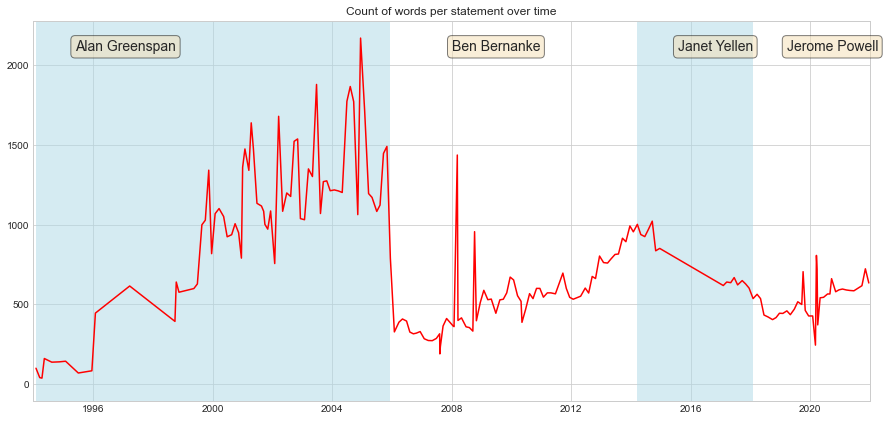

In [55]:
fig, ax = plt.subplots(figsize=(15,7))

Count = Data['wordcount']

ax.plot(Data.index, Count, 
         c = 'red',
         linewidth= 1.5)



plt.title('Count of words per statement over time')

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Speaker,
                facecolor='lightblue', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, "Alan Greenspan", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.50, 0.95, "Ben Bernanke", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.77, 0.95, "Janet Yellen", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.90, 0.95, "Jerome Powell", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

# Preprocess Non-textual Data

In [1]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [19]:
import numpy as np
import pandas as pd
import datetime 
import os
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pickle
from tqdm.notebook import tqdm
import re

In [3]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Load FOMC Meeting
### Chairpersons

In [4]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


In [27]:
# def get_chairperson(x):
#     '''
#     Return a tuple of chairperson's Fullname for the given date x.
#     '''
#     # If x is string, convert to datetime
#     if type(x) is str:
#         try:
#             x = dt.datetime.strftime(x, '%Y-%m-%d')
#         except:
#             return None
    
#     chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
#     return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

$\color {red}{Note:}$ Fixed the big in the `get_chairperson` function 

In [59]:
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try: 
            x = datetime.datetime.strptime(x, '%Y-%m-%d')
        except: 
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [49]:
print(get_chairperson('2021-01-05'))

Jerome Powell


### Load Calendar

In [40]:
file = open('../data/FOMC/fomc_calendar.pickle', 'rb')

fomc_calendar = pd.read_pickle(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(446, 4)


,date,unscheduled,forecast,confcall
0,1980-01-09,False,False,False
1,1980-02-05,False,False,False
2,1980-02-22,False,False,True
3,1980-03-07,False,False,True
4,1980-03-18,False,False,False
...,...,...,...,...
441,2022-06-15,False,True,False
442,2022-07-27,False,False,False
443,2022-09-21,False,True,False
444,2022-11-02,False,False,False


In [42]:
# Take data after 1982/09/27
fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= datetime.datetime(1982, 9, 27)]

# Use date as index
fomc_calendar.set_index('date', inplace=True)
fomc_calendar.head()

,unscheduled,forecast,confcall
date,,,
1982-10-05,False,False,False
1982-11-16,False,False,False
1982-12-21,False,False,False
1983-01-14,False,False,True
1983-01-21,False,False,True


### Add Chairperson to Calendar

In [43]:
fomc_calendar.index

DatetimeIndex(['1982-10-05', '1982-11-16', '1982-12-21', '1983-01-14',
               '1983-01-21', '1983-01-28', '1983-02-09', '1983-03-29',
               '1983-04-29', '1983-05-24',
               ...
               '2021-11-03', '2021-12-15', '2022-01-26', '2022-03-16',
               '2022-05-04', '2022-06-15', '2022-07-27', '2022-09-21',
               '2022-11-02', '2022-12-14'],
              dtype='datetime64[ns]', name='date', length=403, freq=None)

In [60]:
# fomc_calendar['ChairPerson'] = fomc_calendar.index.map(get_chairperson)
# fomc_calendar

## Load Market Data

#### Download from Quandl
Quandl provide APIs and library for each data access to multiple sources.
Created a python function to download data, so please execute it first. api_key can be found on your Quandl Account.

` python QuandlGetData.py [api_key] 1980-01-01 `

Also, it can be accessed via Web API.
```
import quandl
import getpass

# Enter Quandle API Key
quandl.ApiConfig.api_key = getpass.getpass('Enter your API Key for Quandl')

data = quandl.get("FRED/DFEDTAR", start_date="1980-01-01")
```

In [61]:
# FRB changed to range from 2008. So use lower side from 2008 as facing lower bound of zero.
filename_till08 = '../data/MarketData/Quandl/FRED_DFEDTAR.csv'
filename_from08u = '../data/MarketData/Quandl/FRED_DFEDTARU.csv'
filename_from08l = '../data/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtarl], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
# Add difference from previous value
fedrate_df['diff'] = fedrate_df['Rate'].diff()

fedrate_df

/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_1743/1461422323.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))


,Rate,diff
Date,,
1982-09-27,10.25,NaN
1982-09-28,10.25,0.00
1982-09-29,10.25,0.00
1982-09-30,10.25,0.00
1982-10-01,10.00,-0.25
...,...,...
2022-01-15,0.00,0.00
2022-01-16,0.00,0.00
2022-01-17,0.00,0.00


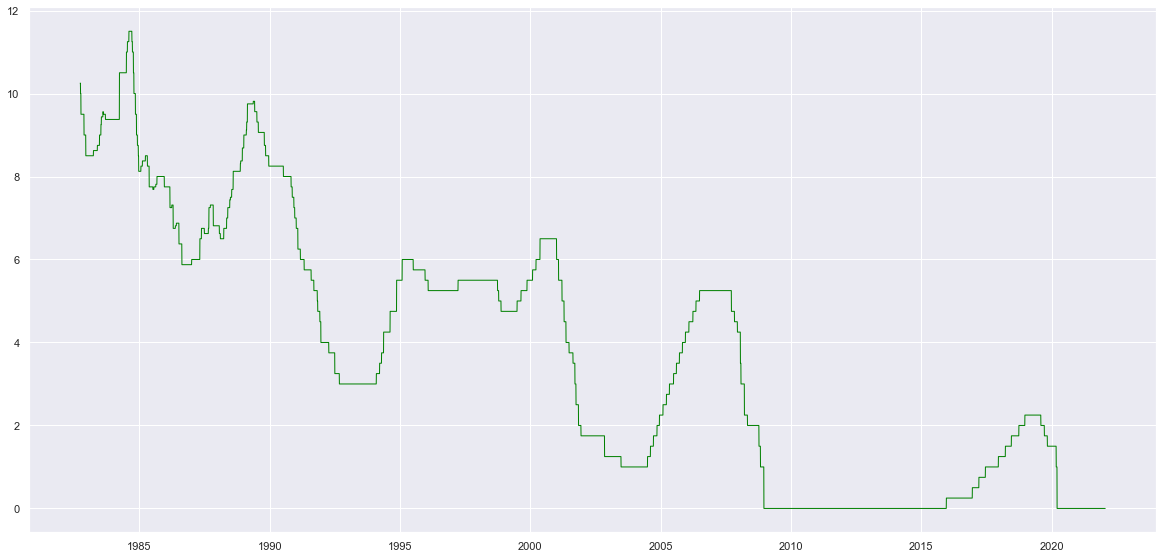

In [62]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

### Effective FED Rate

In [63]:
# Load FED Effective

filename = '../data/MarketData/Quandl/FRED_DFF.csv'

dff = pd.read_csv(filename, names=['DATE', 'DFF'], header=0)
dff = dff.set_index(pd.to_datetime(dff['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
dff['diff'] = dff['DFF'].diff()
dff

,DFF,diff
DATE,,
1980-01-01,14.77,NaN
1980-01-02,14.00,-0.77
1980-01-03,13.89,-0.11
1980-01-04,14.00,0.11
1980-01-05,14.00,0.00
...,...,...
2022-01-15,0.08,0.00
2022-01-16,0.08,0.00
2022-01-17,0.08,0.00


(512, 2)


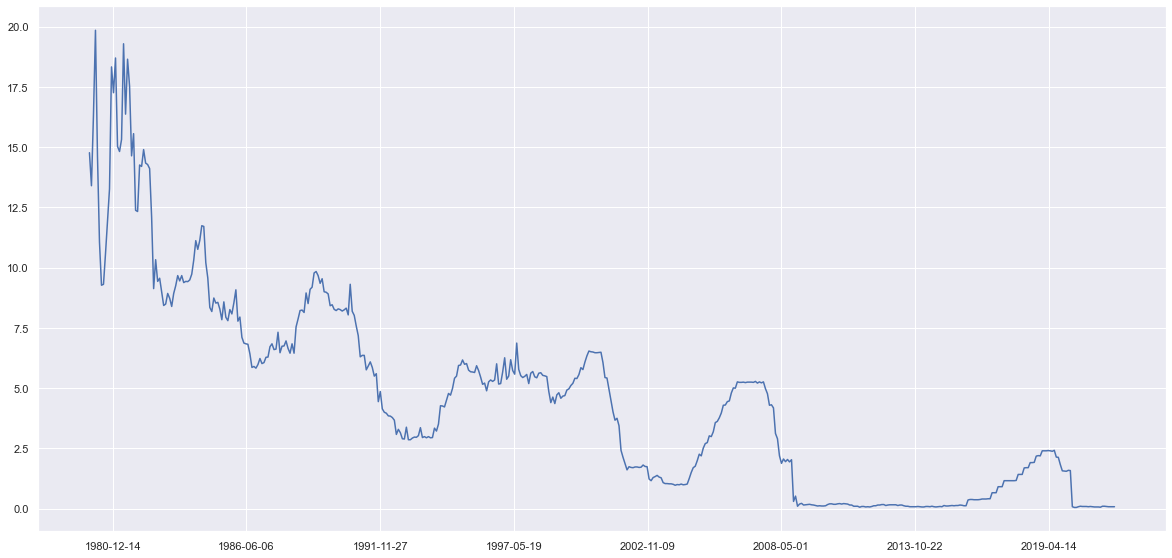

In [64]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30.index.values, dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

## Load Economic Indices

### GDP

Real GDP, Quarterly announced

In [65]:
# Load Real GDP
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate

filename = '../data/MarketData/Quandl/FRED_GDPC1.csv'

gdpc1 = pd.read_csv(filename, names=['DATE', 'GDPC1'], header=0)
gdpc1 = gdpc1.set_index(pd.to_datetime(gdpc1['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdpc1['diff_prev'] = gdpc1['GDPC1'].diff() / gdpc1['GDPC1'].shift(1) * 100 # quarterly change 
gdpc1['diff_year'] = gdpc1['GDPC1'].diff(periods=4) / gdpc1['GDPC1'].shift(4) * 100 # annual change 
gdpc1

,GDPC1,diff_prev,diff_year
DATE,,,
1980-01-01,6842.024,NaN,NaN
1980-04-01,6701.046,-2.060472,NaN
1980-07-01,6693.082,-0.118847,NaN
1980-10-01,6817.903,1.864926,NaN
1981-01-01,6951.495,1.959429,1.599980
...,...,...,...
2020-07-01,18560.774,7.547535,-2.887506
2020-10-01,18767.778,1.115277,-2.262915
2021-01-01,19055.655,1.533890,0.546977


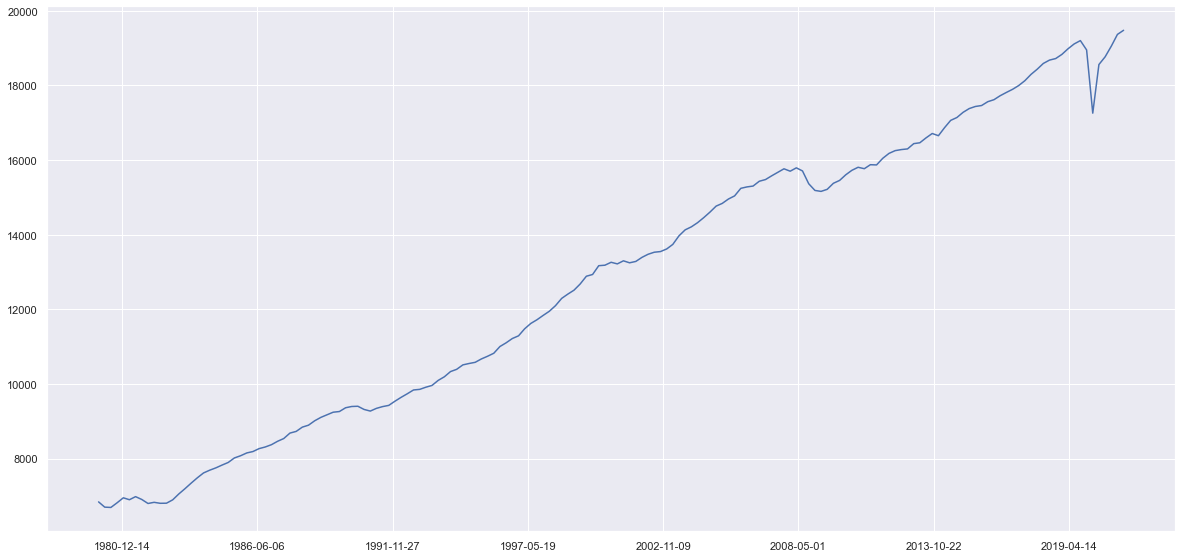

In [66]:
fig, ax = plt.subplots()
ax.plot(gdpc1.index.values, gdpc1['GDPC1'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Potential GDP

In [67]:
# Load Real Potential GDP
# Billions of Chained 2012 Dollars, Not Seasonally Adjusted, adjusted for inflation 

filename = '../data/MarketData/Quandl/FRED_GDPPOT.csv'

gdppot = pd.read_csv(filename, names=['DATE', 'GDPPOT'], header=0)
gdppot = gdppot.set_index(pd.to_datetime(gdppot['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdppot['diff_prev'] = gdppot['GDPPOT'].diff() / gdppot['GDPPOT'].shift(1) * 100
gdppot['diff_year'] = gdppot['GDPPOT'].diff(periods=4) / gdppot['GDPPOT'].shift(4) * 100
gdppot

,GDPPOT,diff_prev,diff_year
DATE,,,
1980-01-01,6847.481683,NaN,NaN
1980-04-01,6890.146039,0.623066,NaN
1980-07-01,6928.061362,0.550283,NaN
1980-10-01,6968.010712,0.576631,NaN
1981-01-01,7012.104757,0.632807,2.404140
...,...,...,...
2030-10-01,23423.370000,0.423458,1.708386
2031-01-01,23522.550000,0.423423,1.706249
2031-04-01,23622.050000,0.422998,1.704632


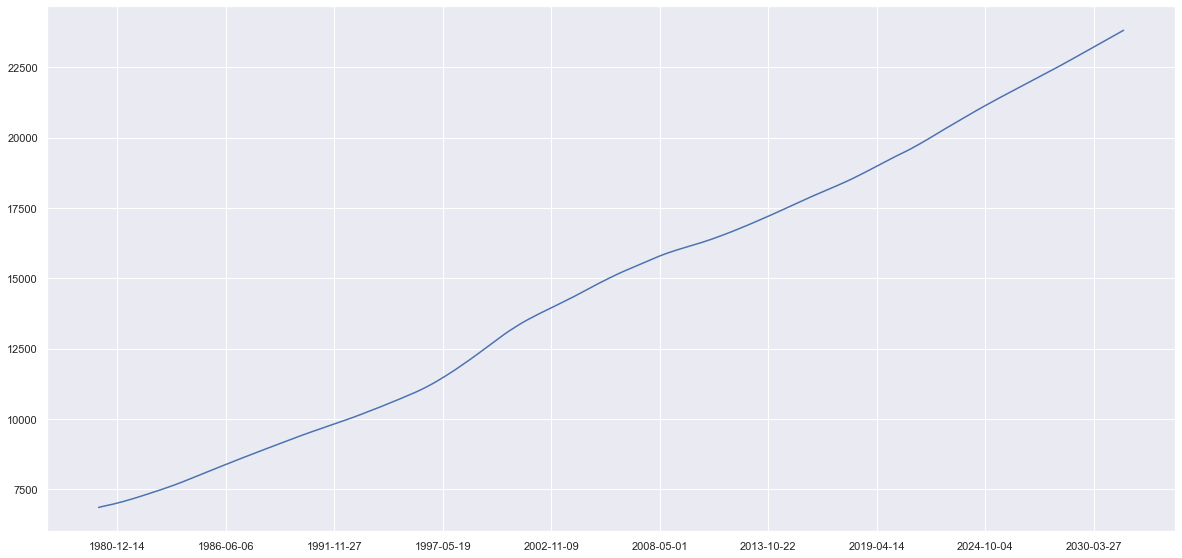

In [68]:
fig, ax = plt.subplots()
ax.plot(gdppot.index.values, gdppot['GDPPOT'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: PCE

Use Core PCE excluding Food and Energy as FRB takes this index as important indicator. <BR />
It is announced monthly around the last working days of each month for the previous month.

In [69]:
# Load Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)
# Index 2012=100, Seasonally Adjusted, Monthly 

filename = '../data/MarketData/Quandl/FRED_PCEPILFE.csv'

pcepilfe = pd.read_csv(filename, names=['DATE', 'PCEPILFE'], header=0)
pcepilfe = pcepilfe.set_index(pd.to_datetime(pcepilfe['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
pcepilfe['diff_prev'] = pcepilfe['PCEPILFE'].diff() / pcepilfe['PCEPILFE'].shift(1) * 100
pcepilfe['diff_year'] = pcepilfe['PCEPILFE'].diff(periods=12) / pcepilfe['PCEPILFE'].shift(12) * 100
pcepilfe

,PCEPILFE,diff_prev,diff_year
DATE,,,
1980-01-01,39.095,NaN,NaN
1980-02-01,39.485,0.997570,NaN
1980-03-01,39.851,0.926934,NaN
1980-04-01,40.056,0.514416,NaN
1980-05-01,40.378,0.803875,NaN
...,...,...,...
2021-07-01,117.704,0.321324,3.603556
2021-08-01,118.073,0.313498,3.599161
2021-09-01,118.357,0.240529,3.702763


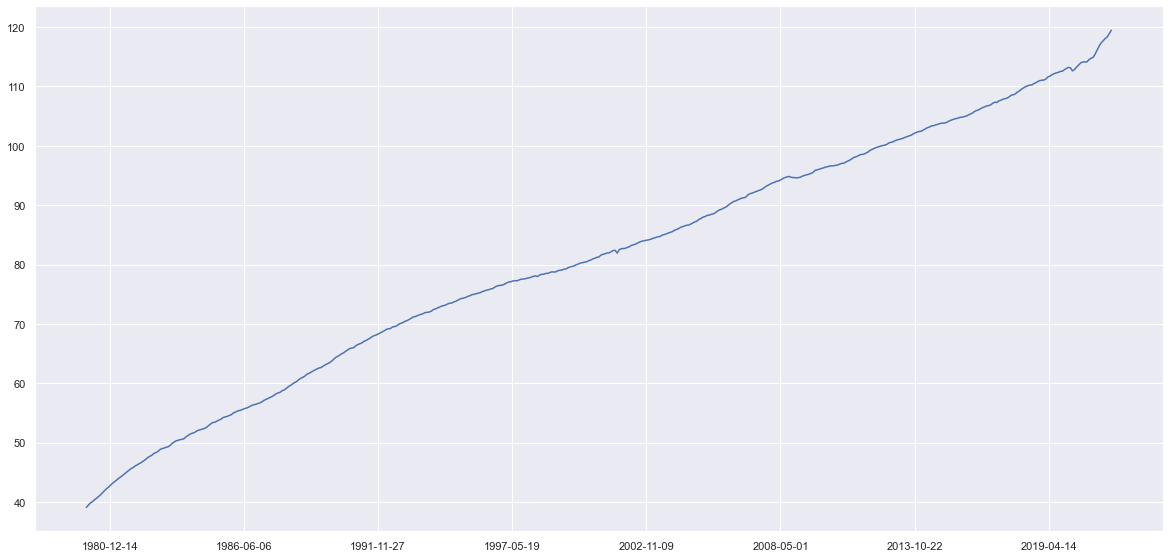

In [70]:
fig, ax = plt.subplots()
ax.plot(pcepilfe.index.values, pcepilfe['PCEPILFE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: CPI

CPI's coverage is less than PCE but announced monthly around 10th of each month for the previous month, which is earlier than PCE. <BR />
As this is available to some meetings even before PCE announcement, take this index as well.

In [71]:
# Load Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
# Index 1982-1984=100, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_CPIAUCSL.csv'

cpiaucsl = pd.read_csv(filename, names=['DATE', 'CPIAUCSL'], header=0)
cpiaucsl = cpiaucsl.set_index(pd.to_datetime(cpiaucsl['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
cpiaucsl['diff_prev'] = cpiaucsl['CPIAUCSL'].diff() / cpiaucsl['CPIAUCSL'].shift(1) * 100
cpiaucsl['diff_year'] = cpiaucsl['CPIAUCSL'].diff(periods=12) / cpiaucsl['CPIAUCSL'].shift(12) * 100
cpiaucsl


,CPIAUCSL,diff_prev,diff_year
DATE,,,
1980-01-01,78.000,NaN,NaN
1980-02-01,79.000,1.282051,NaN
1980-03-01,80.100,1.392405,NaN
1980-04-01,80.900,0.998752,NaN
1980-05-01,81.700,0.988875,NaN
...,...,...,...
2021-08-01,273.012,0.274365,5.202477
2021-09-01,274.138,0.412436,5.377303
2021-10-01,276.724,0.943321,6.243521


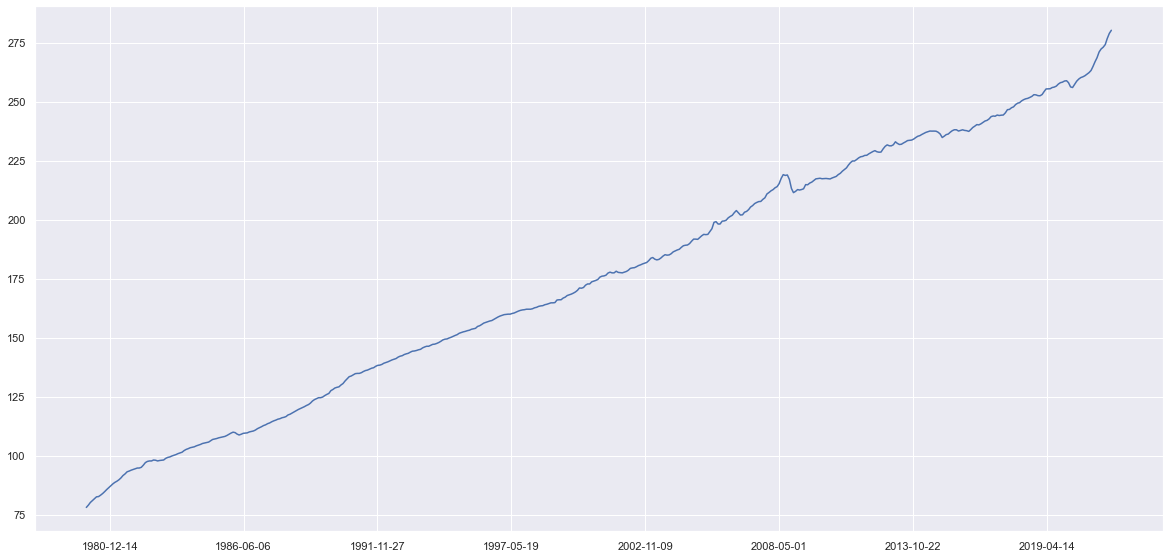

In [72]:
fig, ax = plt.subplots()
ax.plot(cpiaucsl.index.values, cpiaucsl['CPIAUCSL'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Unemployment

Takes unemployment rate as important input for FRB's decision. Real Potential GDP is quarterly and usually two month after each quarter. On the other hand, unemployment is annnounced monthly, around a week after the end of each month and can be more real-time. <BR />
As bigger number indicates negative, turn the sign to have negative number.

In [73]:
# Load Unemployment
# Percent, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_UNRATE.csv'

unrate = pd.read_csv(filename, names=['DATE', 'UNRATE'], header=0)
unrate = unrate.set_index(pd.to_datetime(unrate['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
unrate['UNRATE'] = unrate['UNRATE'] * -1
# Add difference from previous value
unrate['diff_prev'] = unrate['UNRATE'].diff()
unrate['diff_year'] = unrate['UNRATE'].diff(periods=12)
unrate

,UNRATE,diff_prev,diff_year
DATE,,,
1980-01-01,-6.3,NaN,NaN
1980-02-01,-6.3,0.0,NaN
1980-03-01,-6.3,0.0,NaN
1980-04-01,-6.9,-0.6,NaN
1980-05-01,-7.5,-0.6,NaN
...,...,...,...
2021-08-01,-5.2,0.2,3.2
2021-09-01,-4.7,0.5,3.2
2021-10-01,-4.6,0.1,2.3


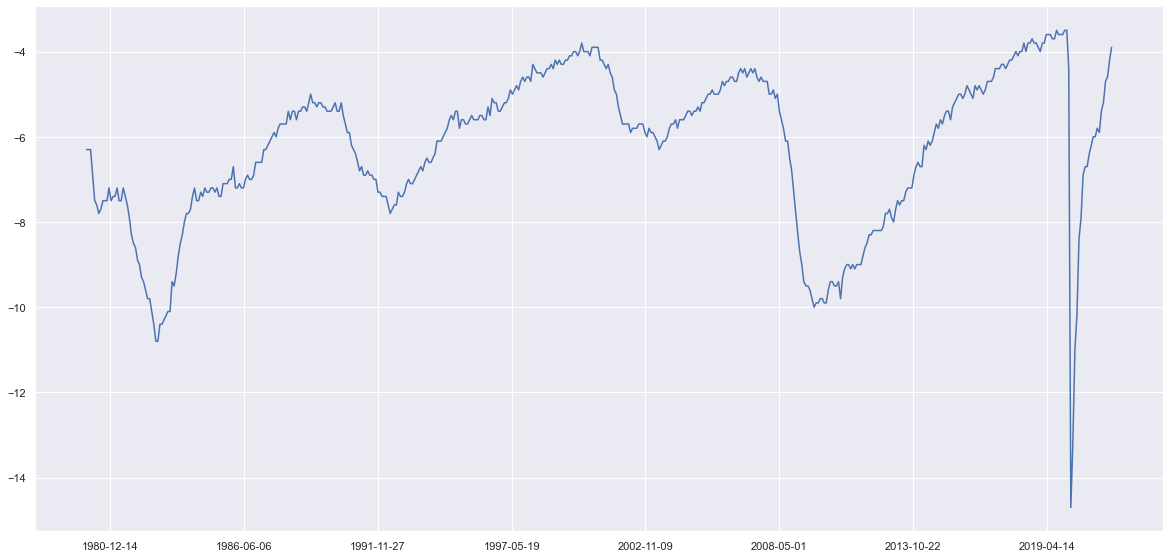

In [74]:
fig, ax = plt.subplots()
ax.plot(unrate.index.values, unrate['UNRATE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Employment

Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed. This measure accounts for approximately 80 percent of the workers who contribute to Gross Domestic Product (GDP).

In [77]:
# Load Employment
# Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_PAYEMS.csv'

payems = pd.read_csv(filename, names=['DATE', 'PAYEMS'], header=0)
payems = payems.set_index(pd.to_datetime(payems['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
payems['diff_prev'] = payems['PAYEMS'].diff()
payems['diff_year'] = payems['PAYEMS'].diff(periods=12)
payems

,PAYEMS,diff_prev,diff_year
DATE,,,
1980-01-01,90800.0,NaN,NaN
1980-02-01,90883.0,83.0,NaN
1980-03-01,90994.0,111.0,NaN
1980-04-01,90849.0,-145.0,NaN
1980-05-01,90420.0,-429.0,NaN
...,...,...,...
2021-08-01,147476.0,483.0,6327.0
2021-09-01,147855.0,379.0,5990.0
2021-10-01,148503.0,648.0,5958.0


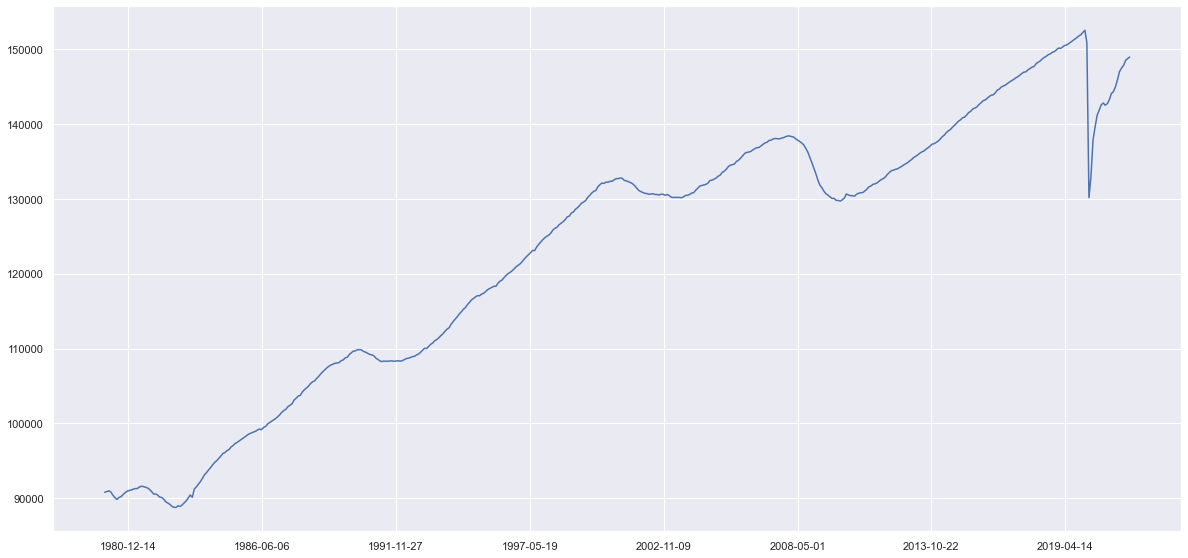

In [78]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['PAYEMS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

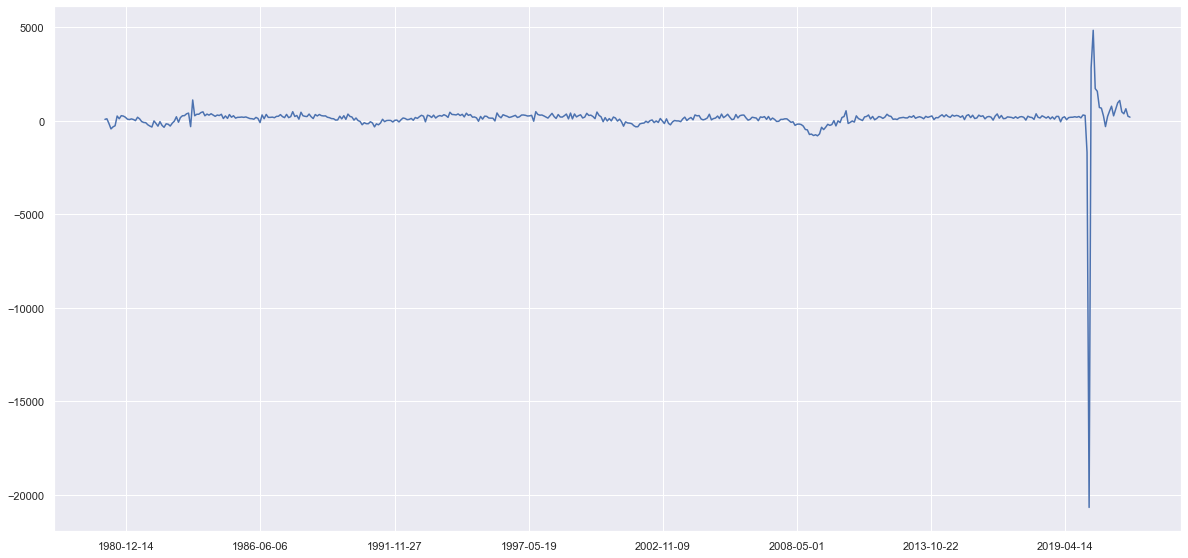

In [79]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['diff_prev'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### ISM Purchasing Managers Index / Non-manufacturing Index

Another important indicator of the economy, also announced monthly right after the end of each month.

In [80]:
# Load ISM (Institute for Summply Management) PMI
filename = '../data/MarketData/Quandl/ISM_MAN_PMI.csv'

ism_pmi = pd.read_csv(filename, names=['Date', 'PMI'], header=0)
ism_pmi = ism_pmi.sort_values(by=['Date'], ascending=True)
ism_pmi = ism_pmi.set_index(pd.to_datetime(ism_pmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_pmi['diff_prev'] = ism_pmi['PMI'].diff()
ism_pmi['diff_year'] = ism_pmi['PMI'].diff(periods=12)
ism_pmi

,PMI,diff_prev,diff_year
Date,,,
1980-01-01,46.2,NaN,NaN
1980-02-01,50.2,4.0,NaN
1980-03-01,43.6,-6.6,NaN
1980-04-01,37.4,-6.2,NaN
1980-05-01,29.4,-8.0,NaN
...,...,...,...
2021-08-01,59.9,0.4,4.3
2021-09-01,61.1,1.2,5.4
2021-10-01,60.8,-0.3,2.0


In [81]:
# Load ISM NMI
filename = '../data/MarketData/Quandl/ISM_NONMAN_NMI.csv'

ism_nmi = pd.read_csv(filename, names=['Date', 'NMI'], header=0)
ism_nmi = ism_nmi.sort_values(by=['Date'], ascending=True)
ism_nmi.columns = ['Date', 'NMI']
ism_nmi = ism_nmi.set_index(pd.to_datetime(ism_nmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_nmi['diff_prev'] = ism_nmi['NMI'].diff()
ism_nmi['diff_year'] = ism_nmi['NMI'].diff(periods=12)
ism_nmi

,NMI,diff_prev,diff_year
Date,,,
2008-01-01,45.0,NaN,NaN
2008-02-01,49.9,4.9,NaN
2008-03-01,49.4,-0.5,NaN
2008-04-01,51.8,2.4,NaN
2008-05-01,51.4,-0.4,NaN
...,...,...,...
2021-08-01,61.7,-2.4,4.5
2021-09-01,61.9,0.2,4.7
2021-10-01,66.7,4.8,10.5


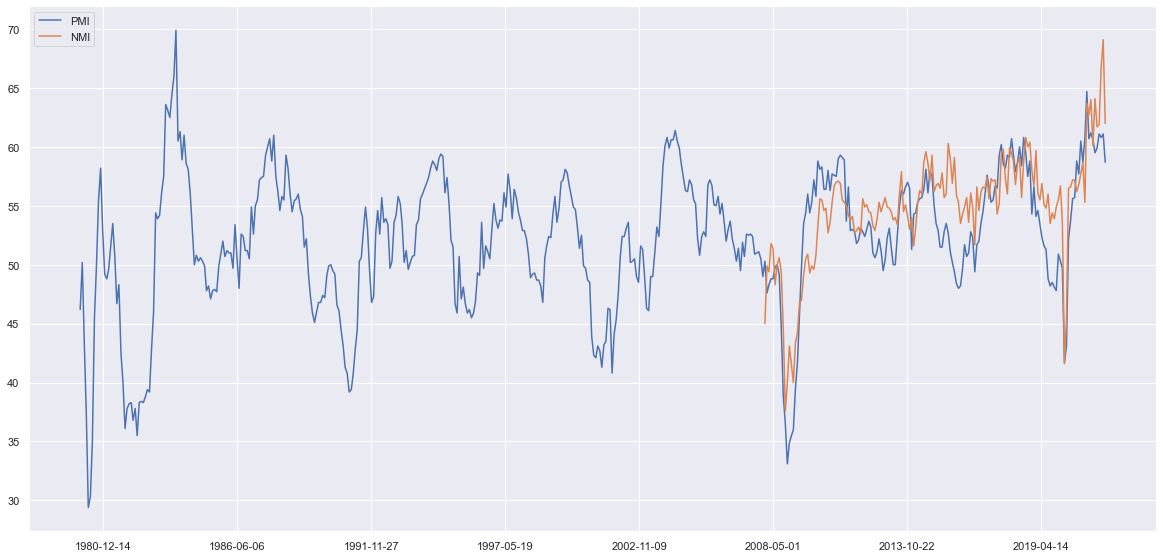

In [82]:
fig, ax = plt.subplots()
ax.plot(ism_pmi.index.values, ism_pmi['PMI'].values)
ax.plot(ism_nmi.index.values, ism_nmi['NMI'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.legend(['PMI', 'NMI'])
plt.show()


Non-manufacturing index (NMI) is available only post 2008. <br /> It cannot cover a lot percentage of the target period, decided not to use it.

### Retail Sales
Retail sales is an important indicator of the current economic situation.
It is usually announced around the middle of each month (15th) for the previous month.

In [83]:
# Load Advance Real Retail and Food Services Sales
# Millions of 1982-84 CPI Adjusted Dollars, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_RRSFS.csv'

rrsfs = pd.read_csv(filename, names=['DATE', 'RRSFS'], header=0)
rrsfs = rrsfs.set_index(pd.to_datetime(rrsfs['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
rrsfs['diff_prev'] = rrsfs['RRSFS'].diff() / rrsfs['RRSFS'].shift(1) * 100
rrsfs['diff_year'] = rrsfs['RRSFS'].diff(periods=12) / rrsfs['RRSFS'].shift(12) * 100
rrsfs


,RRSFS,diff_prev,diff_year
DATE,,,
1992-01-01,118651.0,NaN,NaN
1992-02-01,118480.0,-0.144120,NaN
1992-03-01,117700.0,-0.658339,NaN
1992-04-01,118156.0,0.387426,NaN
1992-05-01,118548.0,0.331765,NaN
...,...,...,...
2021-08-01,227969.0,0.882398,9.967922
2021-09-01,228717.0,0.328115,8.338149
2021-10-01,230591.0,0.819353,9.413434


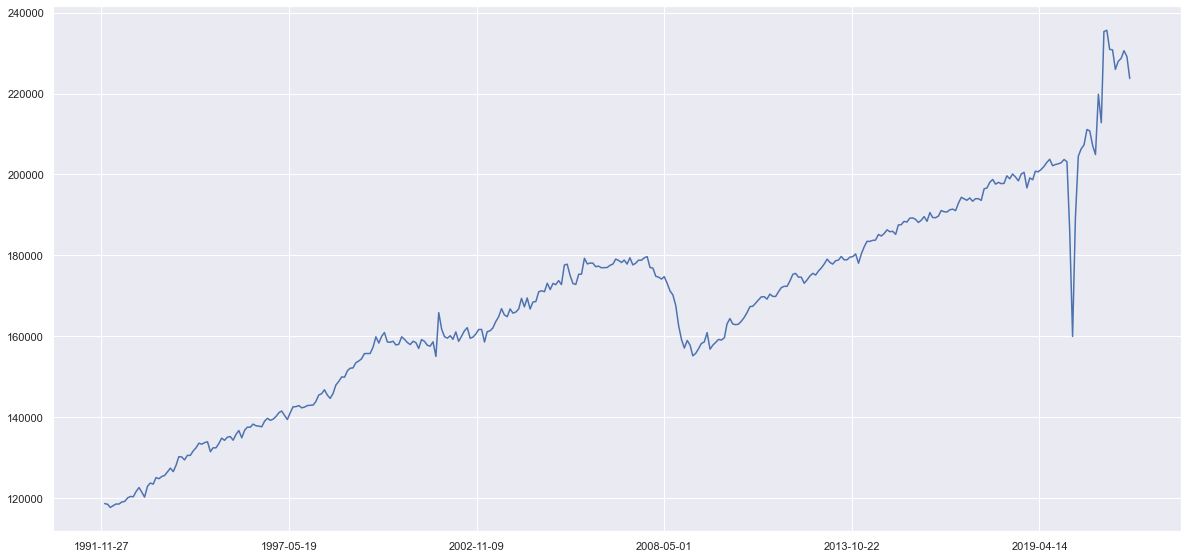

In [84]:
fig, ax = plt.subplots()
ax.plot(rrsfs.index.values, rrsfs['RRSFS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### New Home Sales
New home sales is another important index to know the retail sales figure. <br />
It is usually announced around a week before the end of each month for the previous month.

In [85]:
filename = '../data/MarketData/Quandl/FRED_HSN1F.csv'

hsn1f = pd.read_csv(filename, names=['DATE', 'HSN1F'], header=0)
hsn1f = hsn1f.set_index(pd.to_datetime(hsn1f['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
hsn1f['diff_prev'] = hsn1f['HSN1F'].diff() / hsn1f['HSN1F'].shift(1) * 100
hsn1f['diff_year'] = hsn1f['HSN1F'].diff(periods=12) / hsn1f['HSN1F'].shift(12) * 100
hsn1f

,HSN1F,diff_prev,diff_year
DATE,,,
1980-01-01,592.0,NaN,NaN
1980-02-01,541.0,-8.614865,NaN
1980-03-01,474.0,-12.384473,NaN
1980-04-01,370.0,-21.940928,NaN
1980-05-01,469.0,26.756757,NaN
...,...,...,...
2021-07-01,704.0,3.074671,-27.572016
2021-08-01,668.0,-5.113636,-31.627431
2021-09-01,723.0,8.233533,-25.540680


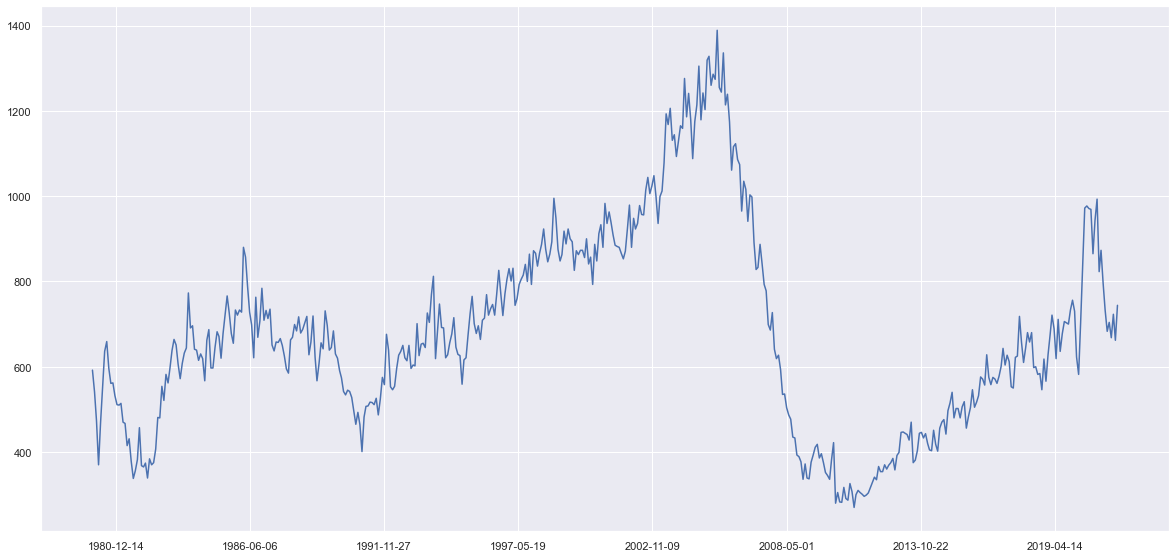

In [86]:
fig, ax = plt.subplots()
ax.plot(hsn1f.index.values, hsn1f['HSN1F'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Treasury Yield
#### Use Quandl

In [87]:
filename = '../data/MarketData/Quandl/USTREASURY_YIELD.csv'

treasury_q = pd.read_csv(filename, header=0)

treasury_q = treasury_q.set_index(pd.to_datetime(treasury_q['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
treasury_q


,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,0.05,0.05,0.12,0.28,0.47,0.91,1.18,1.47,1.64,1.70,2.10,2.05
2022-01-14,0.05,0.05,0.13,0.30,0.51,0.99,1.26,1.55,1.72,1.78,2.18,2.12
2022-01-18,0.05,0.06,0.16,0.37,0.58,1.06,1.35,1.65,1.82,1.87,2.24,2.18


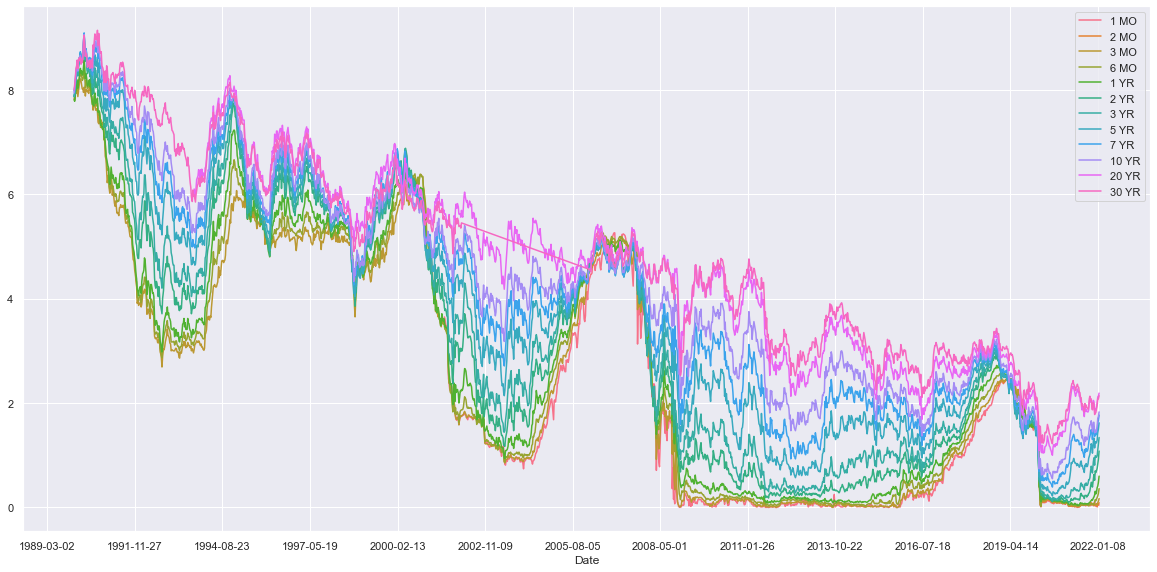

In [88]:
# Use every 5th row as it has too many data points
treasury_q_5 = treasury_q.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_q_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

# Process the data

## Add Rate and Decisions

In [89]:
# The target range was changed a couple of days after the announcement in the past,
#  while it is immediately put in effect on the day recently.
# Use the target rate three days after the meeting as target announced,
#  compare it with previous day's rate to check if rate has been changed.
#   -1: Rate lower
#    0: No change
#   +1: Rate hike

rate_list = []
decision_list = []
rate_diff_list = []

for i in tqdm(range(len(fomc_calendar))):
    not_found = True
    for j in range(len(fedrate_df)):
        if fomc_calendar.index[i] == fedrate_df.index[j]:
            not_found = False
            rate_list.append(float(fedrate_df['Rate'].iloc[j+3]))
            rate_diff_list.append(float(fedrate_df['Rate'].iloc[j+3]) - float(fedrate_df['Rate'].iloc[j-1]))
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(0)
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(1)
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(-1)
            break
    if not_found:
        rate_list.append(np.nan)
        decision_list.append(np.nan)
        rate_diff_list.append(np.nan)

fomc_calendar.loc[:,'Rate'] = rate_list
fomc_calendar.loc[:,'RateDiff'] = rate_diff_list
fomc_calendar.loc[:,'RateDecision'] = decision_list
fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')

fomc_calendar

  0%|          | 0/403 [00:00<?, ?it/s]

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_1743/2190436413.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')


,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision
date,,,,,,
1982-10-05,False,False,False,9.5,-0.5,-1
1982-11-16,False,False,False,9.0,-0.5,-1
1982-12-21,False,False,False,8.5,0.0,0
1983-01-14,False,False,True,8.5,0.0,0
1983-01-21,False,False,True,8.5,0.0,0
...,...,...,...,...,...,...
2022-06-15,False,True,False,NaN,NaN,<NA>
2022-07-27,False,False,False,NaN,NaN,<NA>
2022-09-21,False,True,False,NaN,NaN,<NA>


In [90]:
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision
date,,,,,,
2022-01-26,False,False,False,NaN,NaN,<NA>
2022-03-16,False,True,False,NaN,NaN,<NA>
2022-05-04,False,False,False,NaN,NaN,<NA>
2022-06-15,False,True,False,NaN,NaN,<NA>
2022-07-27,False,False,False,NaN,NaN,<NA>
2022-09-21,False,True,False,NaN,NaN,<NA>
2022-11-02,False,False,False,NaN,NaN,<NA>
2022-12-14,False,True,False,NaN,NaN,<NA>


In [91]:
# Remove the future date
fomc_calendar = fomc_calendar.loc[fomc_calendar.index < dt.datetime.now()]

# Confirm no null rate remains
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision
date,,,,,,
2022-01-26,False,False,False,NaN,NaN,<NA>


In [92]:
# # Calculate the next business day (not used for now)
# from pandas.tseries.holiday import USFederalHolidayCalendar
# cal = USFederalHolidayCalendar()
# holidays = cal.holidays(start='1982-01-01', end='2020-12-31').strftime('%Y-%m-%d')
# bdd = np.busdaycalendar(weekmask='1111100', holidays=holidays)

# np.busday_offset('2011-01-01', np.arange(366), roll='forward', busdaycal=bdd)
# np.busday_offset('1982-10-06', 0, roll='forward', busdaycal=bdd)

Though this is not perfect as Target Rate was sometimes changed between FOMC meetings, enough to analyze the impact of FOMC Meetings.

## Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [ ]:
# Add 2008-11-25 to fomc_calendar when QE was first announced but not in FOMC Calendar
# Mark RateDecision = -1 (lower) even when rate is not changed but additional quantitative measures were announced

# QE1 Announced
rec_20081125 = pd.Series([True, False, False, 'Ben Bernanke', 0, -1, -1], index=['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate', 'RateDiff', 'RateDecision'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d'))

if fomc_calendar.loc[fomc_calendar.index == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    fomc_calendar = fomc_calendar.append(rec_20081125)

# Make the other timings of QE Expansion lowering events (consider the effect as -0.5%)
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2009,3,18), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE1 Expanded
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2010,11,3), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE2 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2011,9,21), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,6,20), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Extended
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,9,13), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,12,12), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Expanded

# It was announced QE ends - regard this as hike
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2013,6,19), ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Announced
fomc_calendar.loc['2013-12-18', ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Begins
fomc_calendar.loc['2014-10-29', ['RateDecision', 'RateDiff']] = (1, 0.5) # QE3 Terminated
fomc_calendar.loc['2017-06-14', ['RateDecision', 'RateDiff']] = (1, 0.5) # Signaled Balance Sheet Normalization
fomc_calendar.loc['2017-09-20', ['RateDecision', 'RateDiff']] = (1, 0.5) # Stated Balance Sheet Normalization Begins in Oct
fomc_calendar.sort_index(ascending=True, inplace=True)
fomc_calendar


In [ ]:
# Add binary column to see if rate is changed
fomc_calendar['RateChanged'] = fomc_calendar['RateDecision'].apply(lambda x: 0 if x == 0 else 1)


In [ ]:
sns.scatterplot(x=fomc_calendar.index, y=fomc_calendar['RateDecision'].apply(lambda x: float(x)))

## Add major economic indices

In [ ]:
def get_available_latest(train_df, index_df, value_col, diff_prev_col, diff_year_col, date_offset):
    '''
    Returns the latest available ecoonmic index for each row of train_df
    INPUTS:
        train_df: Index must be in datetime format
        idex_df: Index must be in datetime format
        value_col: The column name of the value in index_df
        diff_prev_col: The column name of the difference from previous period in index_df
        diff_year_col: The column name of the difference from the same priod in previous year in index_df
        date_offset: Use relativedelta for the offset when the index is published
    OUTPUTS:
        date_list: List of date matched with train_df.index
        value_list: List of values for the date_list
        diff_list: List of diff values for the date_list
    '''
    
    date_list, value_list, diff_prev_list, diff_year_list = [], [], [], []
    
    for i, row_data in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        #print(row_data.name)
        not_available = True
        for j, row_index in index_df.sort_index(ascending=False).iterrows():
            if row_data.name > row_index.name + date_offset:
                #print("   matched: ", row_index.name)
                date_list.append(row_index.name)
                value_list.append(row_index[value_col])
                diff_prev_list.append(row_index[diff_prev_col])
                diff_year_list.append(row_index[diff_year_col])
                not_available = False
                break
        if not_available:
            date_list.append(None)
            value_list.append(None)
            diff_prev_list.append(None)
            diff_year_list.append(None)
    if train_df.shape[0] != len(date_list):
        print("train_df has {} rows but returned {} rows from index_df!".format(train_df.shape[0], len(date_list)))
    
    return date_list, value_list, diff_prev_list, diff_year_list

In [ ]:
def add_market_data(calendar_df, window=1):
    '''
    Search the latest available market data using get_available_latest and retun a new dataframe with the market data.
    Moving average is applied to market data for the give window size.
    '''
    # First copy the caleander dataframe and drop Rate is NaN because this is the answer
    df = calendar_df.copy(deep=True)
    df.dropna(subset=['Rate'], inplace=True)
    
    # GDP is announced quarterly, the end of following month (preliminary)
    print("Processing GDP...")
    df['GDP_date'], df['GDP_value'], df['GDP_diff_prev'], df['GDP_diff_year'] \
    = get_available_latest(df, gdpc1.rolling(window).mean(), 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    print("Processing Potential GDP...")
    df['GDPPOT_date'], df['GDPPOT_value'], df['GDPPOT_diff_prev'], df['GDPPOT_diff_year'] \
    = get_available_latest(df, gdppot.rolling(window).mean(), 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    # PCE is announced monthly, at the end of following month
    print("Processing PCE...")
    df['PCE_date'], df['PCE_value'], df['PCE_diff_prev'], df['PCE_diff_year'] \
    = get_available_latest(df, pcepilfe.rolling(window).mean(), 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))

    # CPI is announced monthly, around 10th of the following month
    print("Processing CPI...")
    df['CPI_date'], df['CPI_value'], df['CPI_diff_prev'], df['CPI_diff_year'] \
    = get_available_latest(df, cpiaucsl.rolling(window).mean(), 'CPIAUCSL', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+9))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Unemployemnt...")
    df['Unemp_date'], df['Unemp_value'], df['Unemp_diff_prev'], df['Unemp_diff_year'] \
    = get_available_latest(df, unrate.rolling(window).mean(), 'UNRATE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Employment...")
    df['Employ_date'], df['Employ_value'], df['Employ_diff_prev'], df['Employ_diff_year'] \
    = get_available_latest(df, payems.rolling(window).mean(), 'PAYEMS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM PMI is areannounced monthly, around 1st of the following month
    print("Processing ISM PMI...")
    df['PMI_date'], df['PMI_value'], df['PMI_diff_prev'], df['PMI_diff_year'] \
    = get_available_latest(df, ism_pmi.rolling(window).mean(), 'PMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM NMI is areannounced monthly, around 1st of the following month
    print("Processing ISM NMI...")
    df['NMI_date'], df['NMI_value'], df['NMI_diff_prev'], df['NMI_diff_year'] \
    = get_available_latest(df, ism_nmi.rolling(window).mean(), 'NMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Retail Sales is announced monthly, around 15th of the following month
    print("Processing Retail Sales...")
    df['Rsales_date'], df['Rsales_value'], df['Rsales_diff_prev'], df['Rsales_diff_year'] \
    = get_available_latest(df, rrsfs.rolling(window).mean(), 'RRSFS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # New Home Sales is announced monthly, around a week before the end of the following month
    print("Processing New Home Sales...")
    df['Hsales_date'], df['Hsales_value'], df['Hsales_diff_prev'], df['Hsales_diff_year'] \
    = get_available_latest(df, hsn1f.rolling(window).mean(), 'HSN1F', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
    
    return df

In [ ]:
nontext_data = add_market_data(fomc_calendar)

In [ ]:
nontext_ma2 = add_market_data(fomc_calendar, 2)
nontext_ma3 = add_market_data(fomc_calendar, 3)
nontext_ma6 = add_market_data(fomc_calendar, 6)
nontext_ma12 = add_market_data(fomc_calendar, 12)

## Add Taylor Rule
After EDA in Notebook No.4, it was found the individual economic index data has little to do with the rate decision. As FED has released how policymakers use these data here, try to calculate them and use instead of raw data. <BR />
https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm

In [ ]:
# Create taylor dataframe
taylor = fedrate_df.copy(deep=True)

# Obtain available index used to calculate Taylor rule each day
_, taylor['Y'],_,_ = get_available_latest(taylor, gdpc1, 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
_, taylor['Yp'],_,_ = get_available_latest(taylor, gdppot, 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
taylor['Y-Yp'] = (np.log(taylor['Y']*10**9) - np.log(taylor['Yp']*10**9)) * 100

_, _,_, taylor['Pi'] = get_available_latest(taylor, pcepilfe, 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))
taylor['Pi*'] = 2
taylor['Pi-Pi*'] = taylor['Pi'] - taylor['Pi*']

taylor['r'] = 2


In [ ]:
# Calculate Taylor Rule
taylor['Taylor'] = taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + 0.5 * taylor['Y-Yp']

# Calculate Balanced-approach Rule
taylor['Balanced'] = (taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + taylor['Y-Yp']).map(lambda x: 0 if x < 0 else x)

# Calculate Inertia Rule
taylor['Inertia'] = 0.85 * taylor['Rate'] - 0.15 * taylor['Balanced']

# Drop unnecessary columns
taylor = taylor.drop(columns = ['Y', 'Yp', 'Y-Yp', 'Pi', 'Pi*', 'Pi-Pi*', 'r', 'diff'])

In [ ]:
# Plot
# Use every 5th row as it has too many data points
# taylor_5 = taylor.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data=taylor, dashes=False, lw=1)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.grid(True)
plt.show()

In [ ]:
# Deviation from Rate, which may trigger the rate change
taylor['Taylor-Rate'] = taylor['Taylor'] - taylor['Rate']
taylor['Balanced-Rate'] = taylor['Balanced'] - taylor['Rate']
taylor['Inertia-Rate'] = taylor['Inertia'] - taylor['Rate']

taylor['Taylor_diff'] = taylor['Taylor'].diff(1)
taylor['Balanced_diff'] = taylor['Balanced'].diff(1)
taylor['Inertia_diff'] = taylor['Inertia'].diff(1)

taylor

In [ ]:
# Add the calculated values to the dataframe
def add_taylor(df, window=1):
    taylor_ma = taylor.rolling(window).mean()
    df['Taylor'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor'].values[0])
    df['Balanced'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced'].values[0])
    df['Inertia'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia'].values[0])
    df['Taylor-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor-Rate'].values[0])
    df['Balanced-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced-Rate'].values[0])
    df['Inertia-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia-Rate'].values[0])
    df['Taylor_diff'] = df['Taylor'].diff(1)
    df['Balanced_diff'] = df['Balanced'].diff(1)
    df['Inertia_diff'] = df['Inertia'].diff(1)
    
    

In [ ]:
add_taylor(nontext_data)
add_taylor(nontext_ma2, 60)
add_taylor(nontext_ma3, 90)
add_taylor(nontext_ma6, 180)
add_taylor(nontext_ma12, 360)

In [ ]:
fomc_calendar.index.get_level_values(0).values

In [ ]:
fomc_calendar.loc['2020-06-10', 'Rate'] = 0
fomc_calendar.loc['2020-07-29', 'Rate'] = 0
fomc_calendar.loc['2020-06-10', 'RateDiff'] = 0
fomc_calendar.loc['2020-07-29', 'RateDiff'] = 0


## Save the train data

In [ ]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save data
save_data(nontext_data, 'nontext_data')
save_data(nontext_ma2, 'nontext_ma2')
save_data(nontext_ma3, 'nontext_ma3')
save_data(nontext_ma6, 'nontext_ma6')
save_data(nontext_ma12, 'nontext_ma12')
save_data(treasury_q, 'treasury')
save_data(fomc_calendar, 'fomc_calendar')

# Clean Text Data

In [ ]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [ ]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [ ]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [ ]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [ ]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [ ]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [ ]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

### Load Calendar

In [ ]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')

fomc_calendar = pd.read_pickle(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

### Statement

In [ ]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pd.read_pickle(file)
file.close()

print(statement_df.shape)
statement_df

In [ ]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

### Meeting Minutes

In [ ]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pd.read_pickle(file)
file.close()

print(minutes_df.shape)
minutes_df

In [ ]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

### Meeting Transcripts

In [ ]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pd.read_pickle(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

In [ ]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

### Press Conference Transcripts

In [ ]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pd.read_pickle(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

In [ ]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

### Speech

In [ ]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pd.read_pickle(file)
file.close()

print(speech_df.shape)
speech_df

In [ ]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

### Testimony

In [ ]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pd.read_pickle(file)
file.close()

print(testimony_df.shape)
testimony_df

In [ ]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

## Statements DataFrame

In [ ]:
statement_df.head()

### Add Quantitative Easing as a Lower event

In [ ]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [ ]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

In [ ]:
# Check the returned dataframe
proc_statement_df

In [ ]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

In [ ]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar.index > x]

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [ ]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df

In [ ]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [ ]:
minutes_df.head()

In [ ]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

In [ ]:
# Check the returned dataframe
proc_minutes_df

In [ ]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [ ]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [ ]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

In [ ]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [ ]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [ ]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [ ]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [ ]:
# Sample
print(presconf_script_df['contents'][2])

In [ ]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


In [ ]:
# Check the returned dataframe
proc_presconf_script_df

In [ ]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [ ]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

In [ ]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

In [ ]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [ ]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

In [ ]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

In [ ]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [ ]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [ ]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df

In [ ]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [ ]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [ ]:
# Sample
print(meeting_script_df['contents'][2])

In [ ]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


In [ ]:
# Check the returned dataframe
proc_meeting_script_df

In [ ]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

In [ ]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [ ]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [ ]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

In [ ]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [ ]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


In [ ]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [ ]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df

In [ ]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [ ]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

In [ ]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

In [ ]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [ ]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


In [ ]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

### Split contents to max 200 words

In [ ]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df

### Filter out by keyword

In [ ]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df

In [ ]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [ ]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

In [ ]:
# Check the returned dataframe
proc_testimony_df

In [ ]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [ ]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

In [ ]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

### Split contents to max 200 words

In [ ]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df

### Filter out by keyword

In [ ]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df

In [ ]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [ ]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [ ]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [ ]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

# EDA and Feature Engineering for Meta Data
## Import necessary libraries

In [ ]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
from collections import defaultdict
from collections import Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
sns.set(style='white', context='notebook', palette='deep')

## Load preprocessed data

In [ ]:
# Load nontext data
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pickle.load(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

In [ ]:
# Load nontext moving average data
file = open('../data/preprocessed/nontext_ma2.pickle', 'rb')
nontext_ma2 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma3.pickle', 'rb')
nontext_ma3 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma6.pickle', 'rb')
nontext_ma6 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma12.pickle', 'rb')
nontext_ma12 = pickle.load(file)
file.close()

# EDA on nontext dataset

In [ ]:
# Add previous rate decision to see inertia effect
nontext_data['prev_decision'] = nontext_data['RateDecision'].shift(1)
nontext_data['next_decision'] = nontext_data['RateDecision'].shift(-1)
nontext_data[['RateDecision', 'prev_decision', 'next_decision']].head()

In [ ]:
# # Take the same period as text dataset (--> Removed as it is determined later)
# nontext_data = nontext_data.loc[nontext_data.index > dt.datetime(1994,1,1)]
# nontext_ma2 = nontext_ma2.loc[nontext_ma2.index > dt.datetime(1994,1,1)]
# nontext_ma3 = nontext_ma3.loc[nontext_ma3.index > dt.datetime(1994,1,1)]
# nontext_ma6 = nontext_ma6.loc[nontext_ma6.index > dt.datetime(1994,1,1)]
# nontext_ma12 = nontext_ma12.loc[nontext_ma12.index > dt.datetime(1994,1,1)]

In [ ]:
nontext_data.describe()

In [ ]:
nontext_data.isnull().sum()

In [ ]:
# The number of data per Target Labels
x = nontext_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
# sns.barplot(x.index, x)
# plt.gca().set_ylabel('number of samples')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=nontext_data)
ax.set_title('nontext_data')

Highly imbalanced to 0 (hold), so need to consider this point. Always predicting 0 (hold) will result in the accuracy of more than 60%. 

## Correlation

In [ ]:
nontext_data.columns.values

In [ ]:
# Per document type
corr_columns = ['RateDecision', 'next_decision', 'prev_decision', 'unscheduled', 'forecast', 'confcall', 
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Rate', 'RateDiff', 'RateChanged']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax)
ax.set_title("Correlation")
plt.show()

### Moving average

In [ ]:
corr_columns = ['RateDecision',
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate']

In [ ]:
# Moving average (window = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(17,8))

sns.heatmap(nontext_data[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Correlation: Original")
ax1.set_xticks([])
ax1.set_yticks([])
sns.heatmap(nontext_ma2[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Correlation: Moving average of 2 periods")
ax2.set_xticks([])
ax2.set_yticks([])
sns.heatmap(nontext_ma3[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax3)
ax3.set_title("Correlation: Moving average of 3 periods")
ax3.set_xticks([])
ax3.set_yticks([])
sns.heatmap(nontext_ma6[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax4)
ax4.set_title("Correlation: Moving average of 6 periods")
ax4.set_xticks([])
ax4.set_yticks([])
sns.heatmap(nontext_ma12[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax5)
ax5.set_title("Correlation: Moving average of 12 periods")
ax5.set_yticks([])

fig.tight_layout(pad=1.0)
plt.show()


Not much improvement. The followings can be used:
 * Unemp_diff_prev for previous 3 period
 * Emp_diff_prev for previous 2 period
 * Rsales_diff_year for previous 2 period
 * Hsales_diff_year for previous 12 period
 * Balanced_diff for previous 12 period
 * Intertia_diff for previous 3 period

In [ ]:
# Correlation between Taylor rule and actual rates are quite high

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

corr_columns = ['Rate', 'Taylor', 'Balanced', 'Inertia']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Rate")

corr_columns = ['RateDiff', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Rate differences")

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=nontext_data[corr_columns], ax=ax)

decision_raise = nontext_data.loc[nontext_data['RateDecision'] == 1]
decision_hold = nontext_data.loc[nontext_data['RateDecision'] == 0]
decision_lower = nontext_data.loc[nontext_data['RateDecision'] == -1]

ax.plot(decision_raise.index.values, decision_raise['Rate'], 'o', color="g", label="Raise")
ax.plot(decision_hold.index.values, decision_hold['Rate'], 'o', color="grey", label="Hold")
ax.plot(decision_lower.index.values, decision_lower['Rate'], 'o', color="r", label="Lower")


### Check individual columns

In [ ]:
def plot_distribution(df, columns):
    for col in columns:        
        fig, ax = plt.subplots(figsize=(10, 5))
        g = sns.kdeplot(df[col][(df["RateDecision"] == -1) & (df[col].notnull())], color="Red", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 0) & (df[col].notnull())], ax=g, color="Blue", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 1) & (df[col].notnull())], ax=g, color="Green", shade=True)
        g.set_xlabel(col)
        g.set_ylabel("Frequency")
        g.set_title("Distribution for " + col, fontsize=14)
        g = g.legend(["Lower", "Hold", "Raise"])
        
        g = sns.FacetGrid(df, col='RateDecision', height=3, aspect=1)
        g.map(sns.distplot, col)


In [ ]:
plot_distribution(nontext_data, ["GDP_diff_prev", "GDP_diff_year", "GDPPOT_diff_prev", "GDPPOT_diff_year"])

In [ ]:
plot_distribution(nontext_data, ["PCE_diff_prev", "PCE_diff_year", "CPI_diff_prev", "CPI_diff_year"])

In [ ]:
plot_distribution(nontext_data, ["Unemp_value", "Unemp_diff_prev", "Unemp_diff_year", "Employ_value", "Employ_diff_prev", "Employ_diff_year"])

In [ ]:
plot_distribution(nontext_data, ["PMI_value", "PMI_diff_prev", "PMI_diff_year"])

In [ ]:
plot_distribution(nontext_data, ["Rsales_diff_prev", "Rsales_diff_year", "Hsales_diff_prev", "Hsales_diff_year"])

In [ ]:
plot_distribution(nontext_data, ["Taylor_diff", "Balanced_diff", "Inertia_diff"])

## Create Training Data Set

In [ ]:
nontext_train_small = pd.concat([nontext_data[['RateDecision', 'prev_decision', 'GDP_diff_prev', 'PMI_value']],
                                 nontext_ma2[['Employ_diff_prev', 'Rsales_diff_year']], 
                                 nontext_ma3[['Unemp_diff_prev', 'Inertia_diff']], 
                                 nontext_ma12[['Hsales_diff_year', 'Balanced_diff']]], axis=1)
nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)

In [ ]:
nontext_train_small.isnull().sum()

In [ ]:
# Large dataset to include all the latest figures plus 3 months rolling average

latest_columns = ['RateDecision', 'prev_decision',
                  'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                  'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

ma3_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
               'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
               'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
               'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
               'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
               'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
               'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

nontext_train_large = pd.concat([nontext_data[latest_columns], nontext_ma3[ma3_columns].add_suffix('_ma3')], axis=1)
nontext_train_large.rename(columns={'RateDecision': 'target'}, inplace=True)
print(nontext_data[latest_columns].shape)
print(nontext_ma3[ma3_columns].shape)
print(nontext_train_large.shape)

In [ ]:
nontext_train_large.isnull().sum()

### Missing Values

In [ ]:
# As most likely the decision is 0 (hold), fill prev_decision of the first row
nontext_train_small['prev_decision'].fillna(0, inplace=True)
nontext_train_large['prev_decision'].fillna(0, inplace=True)

In [ ]:
ax = sns.lineplot(data=nontext_train_small['Rsales_diff_year'].values)
ax.set_xlim(0, 400)

In [ ]:
ax = sns.lineplot(data=nontext_ma2['Hsales_diff_year'].values)
ax.set_xlim(0, 400)

In [ ]:
# Retail sales growth ratio is difficult to estimate. Though it is not ideal, simply use the average
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)
nontext_train_large['Rsales_diff_prev'].fillna(nontext_train_large['Rsales_diff_prev'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year'].fillna(nontext_train_large['Rsales_diff_year'].mean(), inplace=True)

nontext_train_small['Inertia_diff'].fillna(nontext_train_small['Inertia_diff'].mean(), inplace=True)
nontext_train_small['Balanced_diff'].fillna(nontext_train_small['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Inertia_diff'].fillna(nontext_train_large['Inertia_diff'].mean(), inplace=True)
nontext_train_large['Balanced_diff'].fillna(nontext_train_large['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Taylor_diff'].fillna(nontext_train_large['Taylor_diff'].mean(), inplace=True)

nontext_train_large['Rsales_diff_prev_ma3'].fillna(nontext_train_large['Rsales_diff_prev_ma3'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year_ma3'].fillna(nontext_train_large['Rsales_diff_year_ma3'].mean(), inplace=True)

nontext_train_large['Inertia_diff_ma3'].fillna(nontext_train_large['Inertia_diff_ma3'].mean(), inplace=True)
nontext_train_large['Balanced_diff_ma3'].fillna(nontext_train_large['Balanced_diff_ma3'].mean(), inplace=True)
nontext_train_large['Taylor_diff_ma3'].fillna(nontext_train_large['Taylor_diff_ma3'].mean(), inplace=True)
nontext_train_large['Inertia-Rate_ma3'].fillna(nontext_train_large['Inertia-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Balanced-Rate_ma3'].fillna(nontext_train_large['Balanced-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Taylor-Rate_ma3'].fillna(nontext_train_large['Taylor-Rate_ma3'].mean(), inplace=True)


In [ ]:
nontext_train_small.isnull().sum()

In [ ]:
nontext_train_large.isnull().sum()

### One-hot encoding

In [ ]:
# nontext_train['Lower'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == -1 else 0)
# nontext_train['Hold'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 0 else 0)
# nontext_train['Raise'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 1 else 0)
# nontext_train

# Save Data

In [ ]:
def save_data(df, file_name, dir_name='../data/train_data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save non-text data
save_data(nontext_train_small, 'nontext_train_small')
save_data(nontext_train_large, 'nontext_train_large')